In [19]:
import pandas as pd
import yfinance as yf
from collections import defaultdict
from statistics import stdev, mean
import matplotlib.pyplot as plt
import numpy as np

In [2]:
tickers = ['TSLA', 'META', 'MSFT', 'GOOG', 'INTC', 'NVDA', 'AMD', 'AAPL', 'AMZN', 'NFLX']
# download 10 years worth of daily closing prices for all 10 stocks
df_nasdaq_10 = yf.download(tickers, '2015-01-01', '2024-12-31')
df_nasdaq_10.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


Price           Close                                                  \
Ticker           AAPL   AMD     AMZN       GOOG       INTC       META   
Date                                                                    
2015-01-02  24.320429  2.67  15.4260  26.045292  27.896461  78.082001   
2015-01-05  23.635284  2.66  15.1095  25.502359  27.581894  76.827919   
2015-01-06  23.637512  2.63  14.7645  24.911289  27.067846  75.792793   
2015-01-07  23.968960  2.58  14.9210  24.868612  27.635593  75.792793   
2015-01-08  24.889904  2.61  15.0230  24.947023  28.149635  77.813271   

Price                                                  ...     Volume  \
Ticker           MSFT       NFLX      NVDA       TSLA  ...       AAPL   
Date                                                   ...              
2015-01-02  40.072132  49.848572  0.483099  14.620667  ...  212818400   
2015-01-05  39.703636  47.311428  0.474939  14.006000  ...  257142000   
2015-01-06  39.120903  46.501431  0.460540  14.085333  ...  263188400   
2015-01-07  39.617943  46.742859  0.459340  14.063333  ...  160423600   
2015-01-08  40.783424  47.779999  0.476619  14.041333  ...  237458000   

Price                                                                   \
Ticker           AMD      AMZN      GOOG      INTC      META      MSFT   
Date                                                                     
2015-01-02         0  55664000  28951268  23605600  18177500  27913900   
2015-01-05   8878200  55484000  41196796  32785000  26452200  39673900   
2015-01-06  13912500  70380000  57998800  30847600  27399300  36447900   
2015-01-07  12377600  52806000  41301082  27725200  22045300  29114100   
2015-01-08  11136600  61768000  67071641  31765400  23961000  29645200   

Price                                      
Ticker          NFLX       NVDA      TSLA  
Date                                       
2015-01-02  13475000  113680000  71466000  
2015-01-05  18165000  197952000  80527500  
2015-01-06  16037700  197764000  93928500  
2015-01-07   9849700  321808000  44526000  
2015-01-08   9601900  283780000  51637500  

[5 rows x 50 columns]

In [3]:
def take(series, i):
    return [x[i] for x in series]

def first(series):
    return take(series, 0)

def second(series):
    return take(series, 1)

def extract_series(df, ticker, metric):
    return list(zip(list(df.index.astype(str)), list(df[metric][ticker])))

def execute_strategy(prices, take_profit_price=None, stop_loss_price=None):
    for days, daily_price in enumerate(prices):
        if take_profit_price is not None:
            if daily_price >= take_profit_price:
                return take_profit_price, days+1
        if stop_loss_price is not None:
            if daily_price <= stop_loss_price:
                return stop_loss_price, days+1
    return prices[-1], len(prices)

def strategy_returns(prices, position_length, take_profit=None, stop_loss=None):
    returns = []
    for i, start_price in enumerate(prices[:-(position_length)]):
        final_price, active_days = execute_strategy(
            prices=prices[i+1:i+position_length+1],
            take_profit_price=start_price*take_profit if take_profit is not None else None,
            stop_loss_price=start_price*stop_loss if stop_loss is not None else None,
        )
        r = (final_price - start_price) / start_price
        daily_normalized_return = np.exp(np.log(1+r)/active_days)-1
        returns.append(daily_normalized_return)
    return returns

daily_strategy = lambda prices: strategy_returns(prices, position_length=1, take_profit=None, stop_loss=None)

# metric functions:

def win_ratio(returns):
    return sum(1 for r in returns if r > 0) / len(returns)

def mean_return(returns):
    return np.mean(returns)

def sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

def strategy_goodness(df, tickers, price_metric, metric_func, strategy_func, annualize=False):
    qs = []
    for ticker in tickers:
        prices = second(extract_series(df, ticker, price_metric))
        returns = strategy_func(prices)
        q = metric_func(returns)
        if np.isnan(q) or q > 100: continue
        qs.append(q)
    q = np.mean(qs)
    if q > 100: print(qs)
    if annualize:
        return (1+q)**252 - 1
    else:
        return q

def plot_goodness(df, tickers, price_metric, metric_func, metric_text, annualize=False, take_profit_mul=1.0):
    monthly_trading_days = 21
    position_lengths = [1, 3, 6, 9, 12, 24, 36]
    deltas = np.arange(0.1, 1.0, 0.1)
    qs = defaultdict(lambda: [])
    for position_length in position_lengths:
        for delta in deltas:
            q = strategy_goodness(
                df=df, tickers=tickers, price_metric='Close',
                metric_func=metric_func,
                strategy_func=lambda prices: strategy_returns(prices, position_length*monthly_trading_days,
                                                              take_profit=1.0 + take_profit_mul*delta,
                                                              stop_loss=  1.0 -                 delta),
                annualize=annualize,
            )
            qs[position_length].append((delta, q))
    legends = []
    plt.figure(figsize=(7, 7))
    for position_length in position_lengths:
        legends.append(f'position length={position_length} mos')
        plt.plot(first(qs[position_length]), second(qs[position_length]), marker='o')
    plt.xlabel(f'take profit and stop loss Δ')
    plt.ylabel(f'mean {metric_text}')
    plt.xlim((0.0, 1.0))
    plt.legend(legends)

def plot_goodness_all(df, tickers, price_metric, take_profit_mul=1.0):
    monthly_trading_days = 21
    position_lengths = [1, 3, 6, 9, 12, 24, 36]
    deltas = np.arange(0.1, 1.0, 0.1)
    metric_funcs = [
        (win_ratio, "win ratio", False),
        (mean_return, "return", True),
        (sharpe_ratio, "sharpe ratio", False),
    ]
    fig, axes = plt.subplots(1, len(metric_funcs), sharex=True, sharey=False, figsize=(18, 6))
    plt.xlabel(f'take profit and stop loss Δ')
    plt.suptitle(f'mean statistics for {tickers if len(tickers)>1 else tickers[0]} for 10 years ending in 2024',)
    for ax, (metric_func, metric_text, annualize) in zip(axes, metric_funcs):
        qs = defaultdict(lambda: [])
        for position_length in position_lengths:
            for delta in deltas:
                q = strategy_goodness(
                    df=df, tickers=tickers, price_metric='Close',
                    metric_func=metric_func,
                    strategy_func=lambda prices: strategy_returns(prices, position_length*monthly_trading_days,
                                                                  take_profit=1.0 + take_profit_mul*delta,
                                                                  stop_loss=  1.0 -                 delta),
                    annualize=annualize,
                )
                qs[position_length].append((delta, q))
        legends = []
        for position_length in position_lengths:
            legends.append(f'position length={position_length} mos')
            ax.plot(first(qs[position_length]), second(qs[position_length]), marker='o')
        ax.set_xlabel(f'take profit and stop loss Δ')
        ax.set_ylabel(f'mean {metric_text}')
        ax.set_xlim((0.0, 1.0))
        plt.legend(legends)

def plot_yearly_goodness(df, tickers, price_metric, metric_func, metric_text, position_length, annualize=False, take_profit_mul=1.0):
    monthly_trading_days = 21
    deltas = np.arange(0.1, 1.0, 0.1)
    years = np.arange(2015, 2025)
    qs = defaultdict(lambda: [])
    for year in years:
        for delta in deltas:
            df_slice = df.loc[(df.index >= f'{year}-01-01') & (df.index < f'{year}-12-31')]
            q = strategy_goodness(
                df=df_slice, tickers=tickers, price_metric='Close',
                metric_func=metric_func,
                strategy_func=lambda prices: strategy_returns(prices, position_length*monthly_trading_days,
                                                              take_profit=1.0 + take_profit_mul*delta,
                                                              stop_loss=  1.0 -                 delta),
                annualize=annualize,
            )
            qs[year].append((delta, q))
    legends = []
    plt.figure(figsize=(7, 7))
    for year in years:
        legends.append(f'year={year}')
        plt.plot(first(qs[year]), second(qs[year]), marker='o')
    plt.title(f'position length={position_length}')
    plt.xlabel(f'take profit and stop loss Δ')
    plt.ylabel(f'mean {metric_text}')
    plt.xlim((0.0, 1.0))
    plt.legend(legends)

def plot_yearly_goodness_all(df, tickers, price_metric, position_length, take_profit_mul=1.0):
    monthly_trading_days = 21
    deltas = np.arange(0.1, 1.0, 0.1)
    years = np.arange(2015, 2025)
    metric_funcs = [
        (win_ratio, "win ratio", False),
        (mean_return, "return", True),
        (sharpe_ratio, "sharpe ratio", False),
    ]
    fig, axes = plt.subplots(1, len(metric_funcs), sharex=True, sharey=False, figsize=(18, 6))
    plt.suptitle(f'annual statistics for {tickers if len(tickers)>1 else tickers[0]} with position length={position_length} for 10 years ending in 2024')
    plt.xlabel(f'take profit and stop loss Δ')
    for ax, (metric_func, metric_text, annualize) in zip(axes, metric_funcs):
        qs = defaultdict(lambda: [])
        for year in years:
            for delta in deltas:
                df_slice = df.loc[(df.index >= f'{year}-01-01') & (df.index < f'{year}-12-31')]
                q = strategy_goodness(
                    df=df_slice, tickers=tickers, price_metric='Close',
                    metric_func=metric_func,
                    strategy_func=lambda prices: strategy_returns(prices, position_length*monthly_trading_days,
                                                                  take_profit=1.0 + take_profit_mul*delta,
                                                                  stop_loss=  1.0 -                 delta),
                    annualize=annualize,
                )
                qs[year].append((delta, q))
        legends = []
        for year in years:
            legends.append(f'year={year}')
            ax.plot(first(qs[year]), second(qs[year]), marker='o')
        ax.set_xlabel(f'take profit and stop loss Δ')
        ax.set_ylabel(f'mean {metric_text}')
        ax.set_xlim((0.0, 1.0))
        plt.legend(legends)

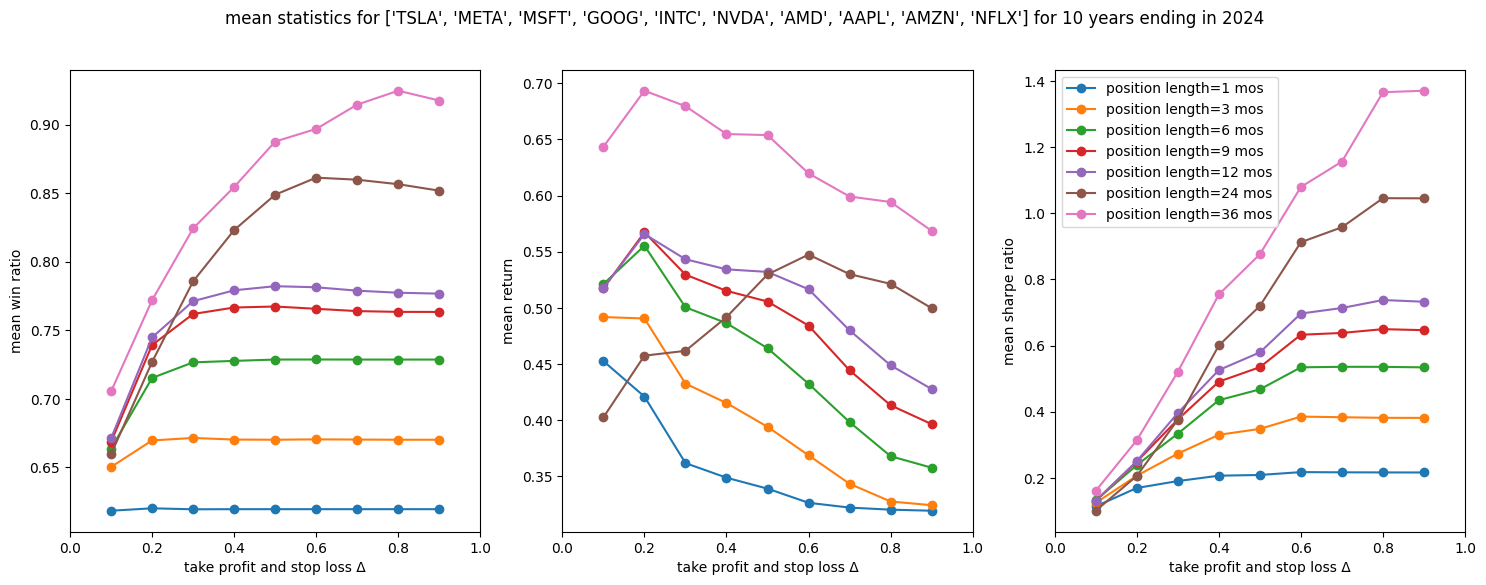

In [4]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
)

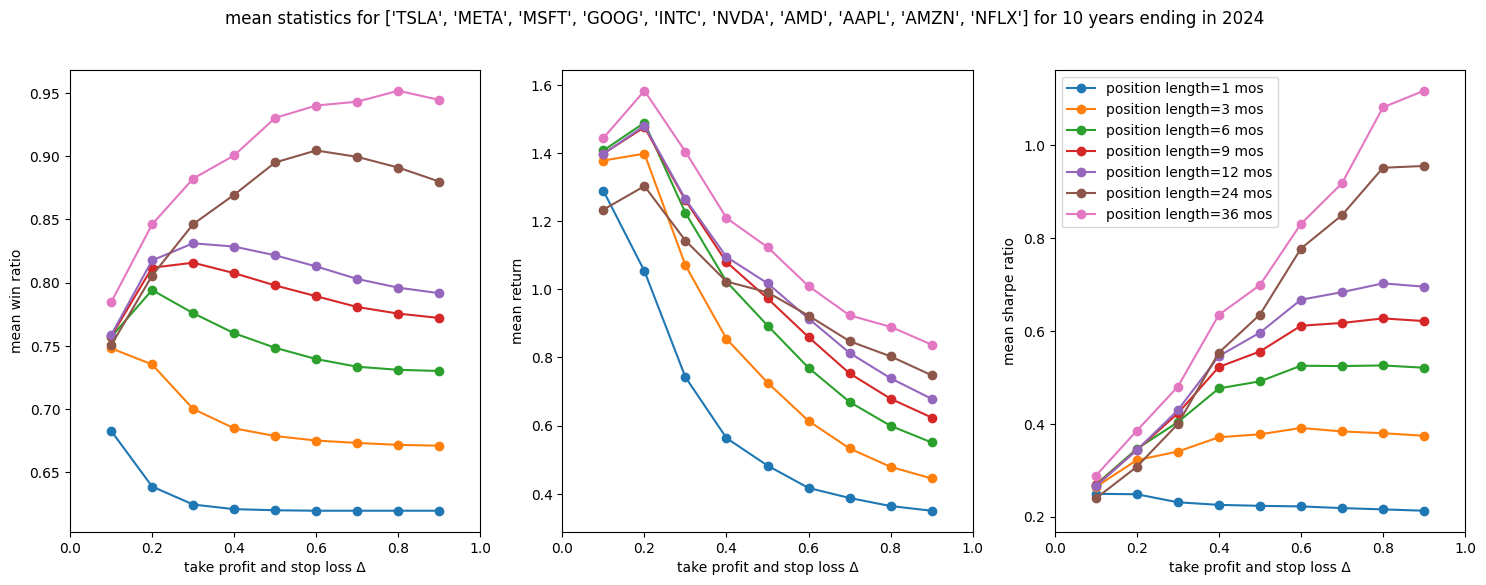

In [5]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
    take_profit_mul=0.5,
)

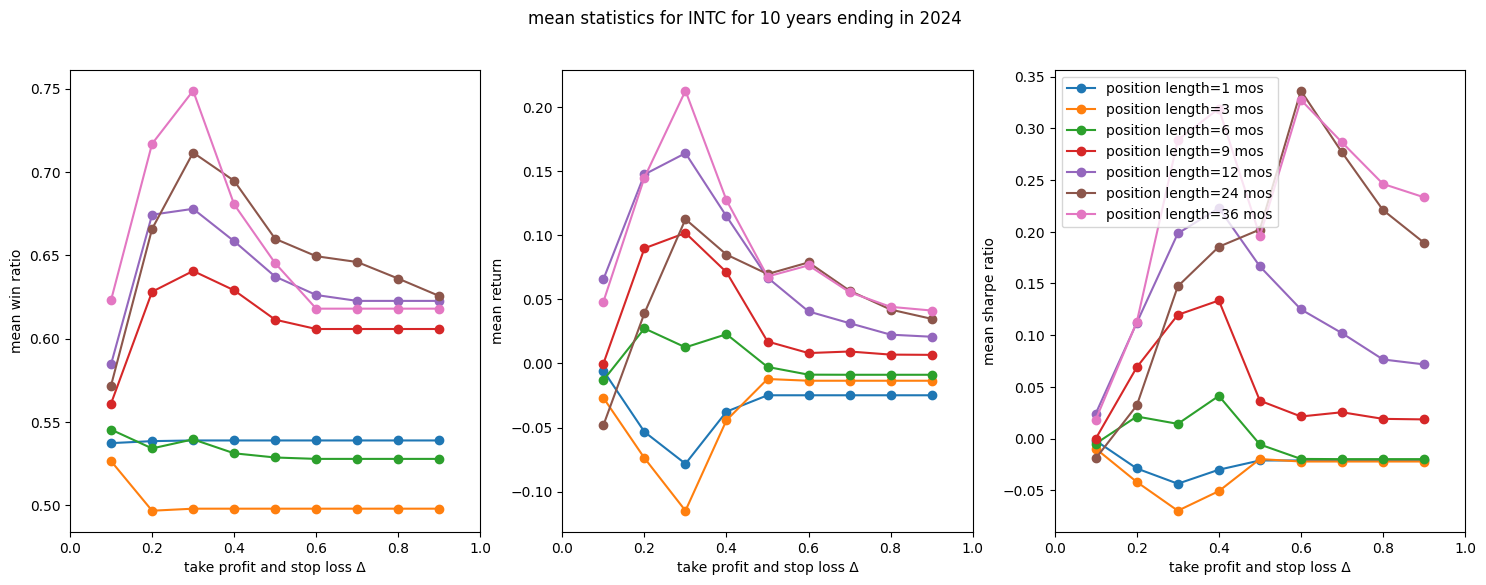

In [6]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=['INTC'], price_metric='Close',
)

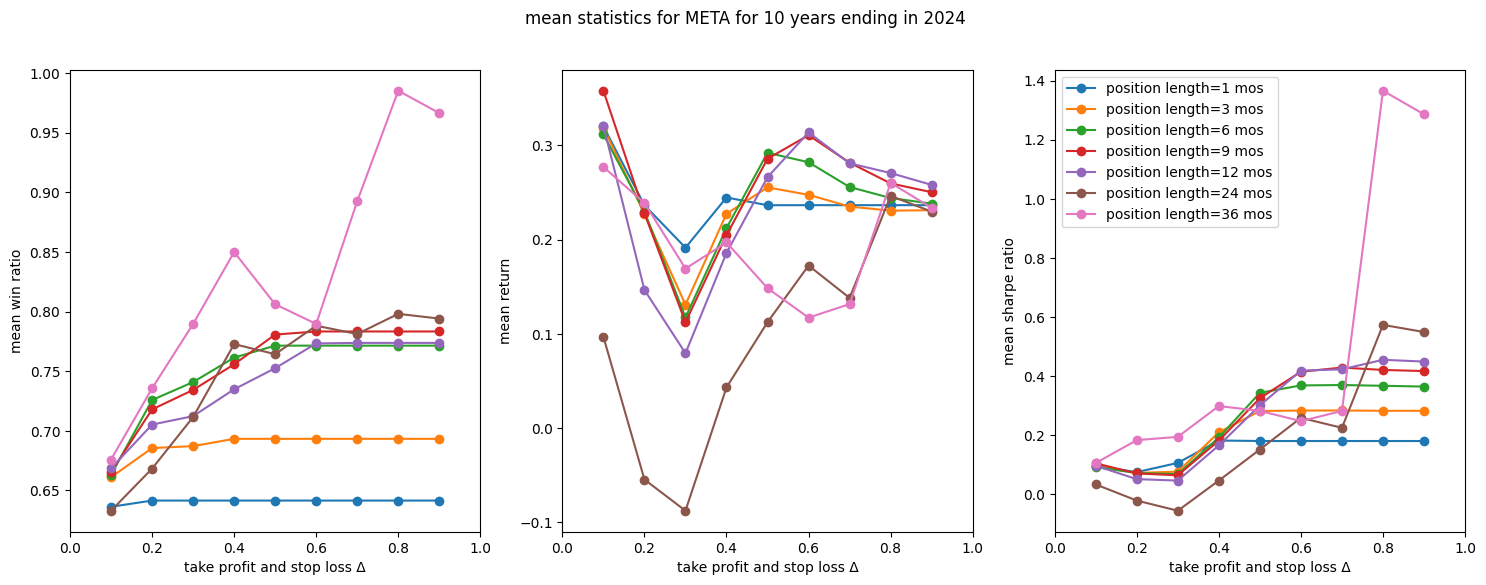

In [7]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=['META'], price_metric='Close',
)

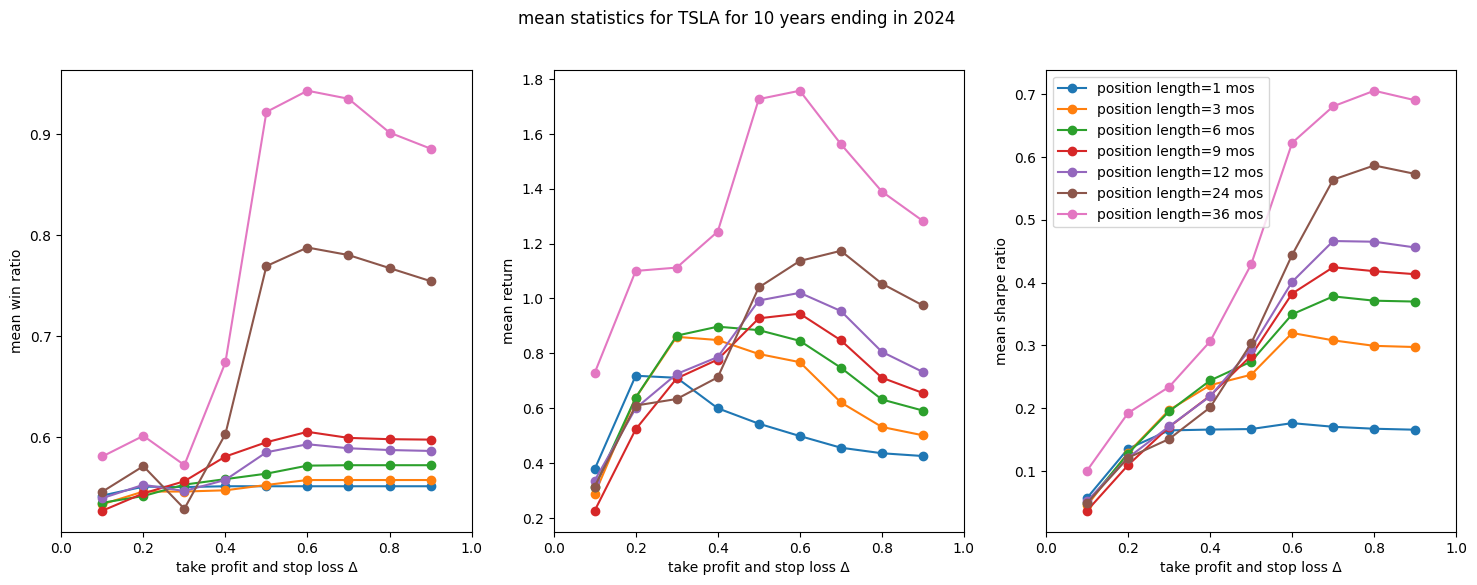

In [8]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=['TSLA'], price_metric='Close',
)

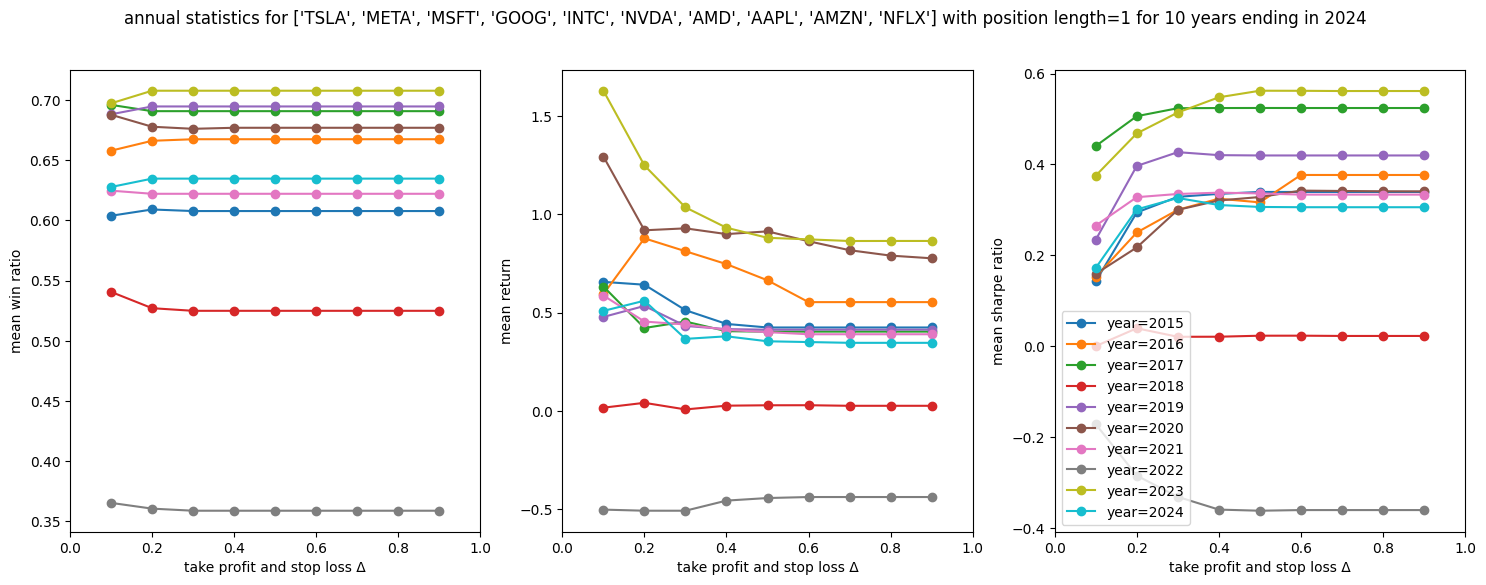

In [9]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
    position_length=1,
)

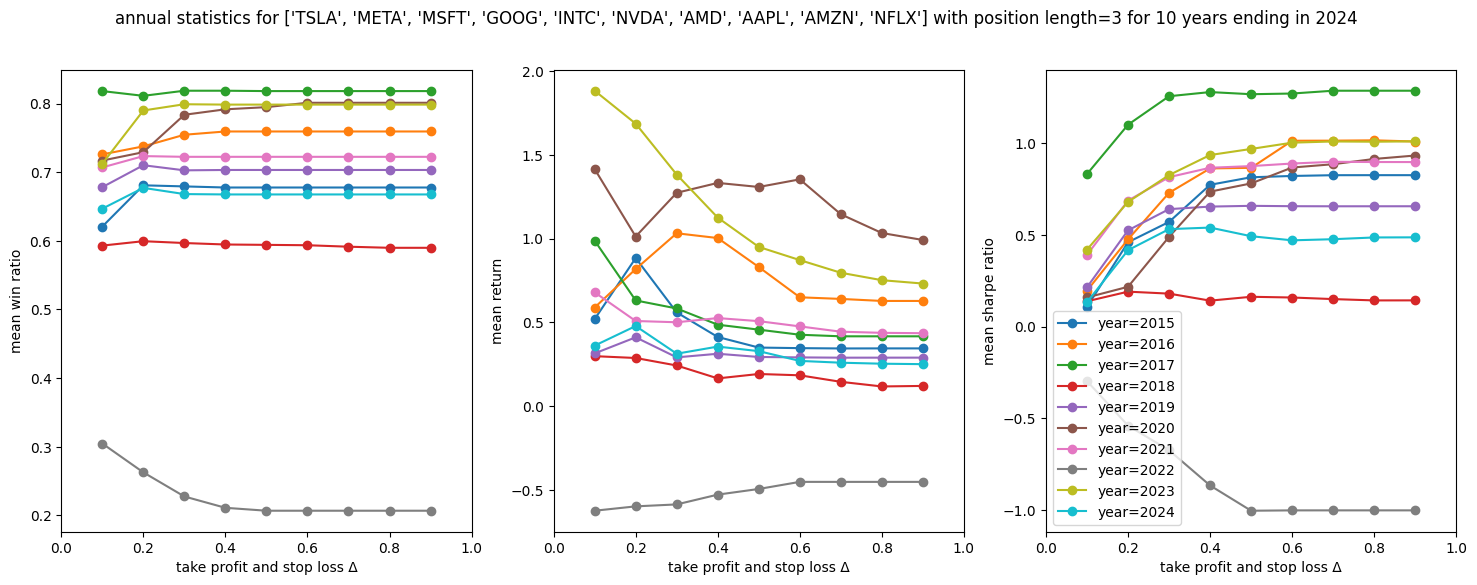

In [10]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
    position_length=3,
)

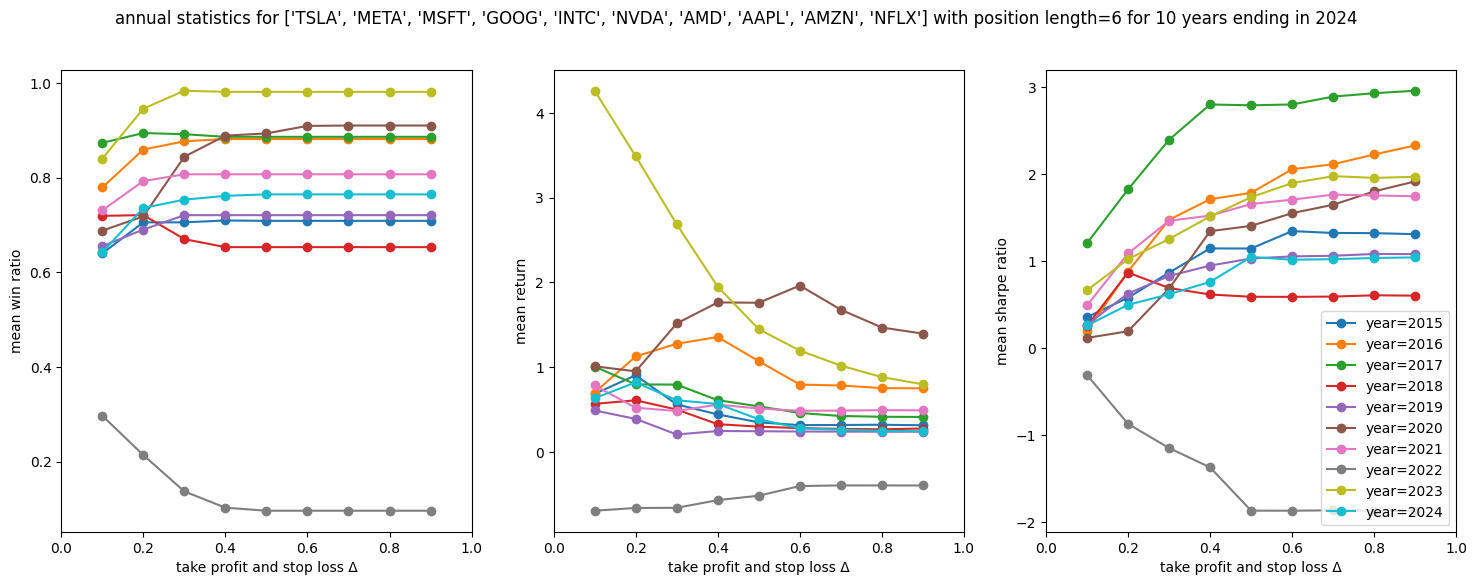

In [11]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
    position_length=6,
)

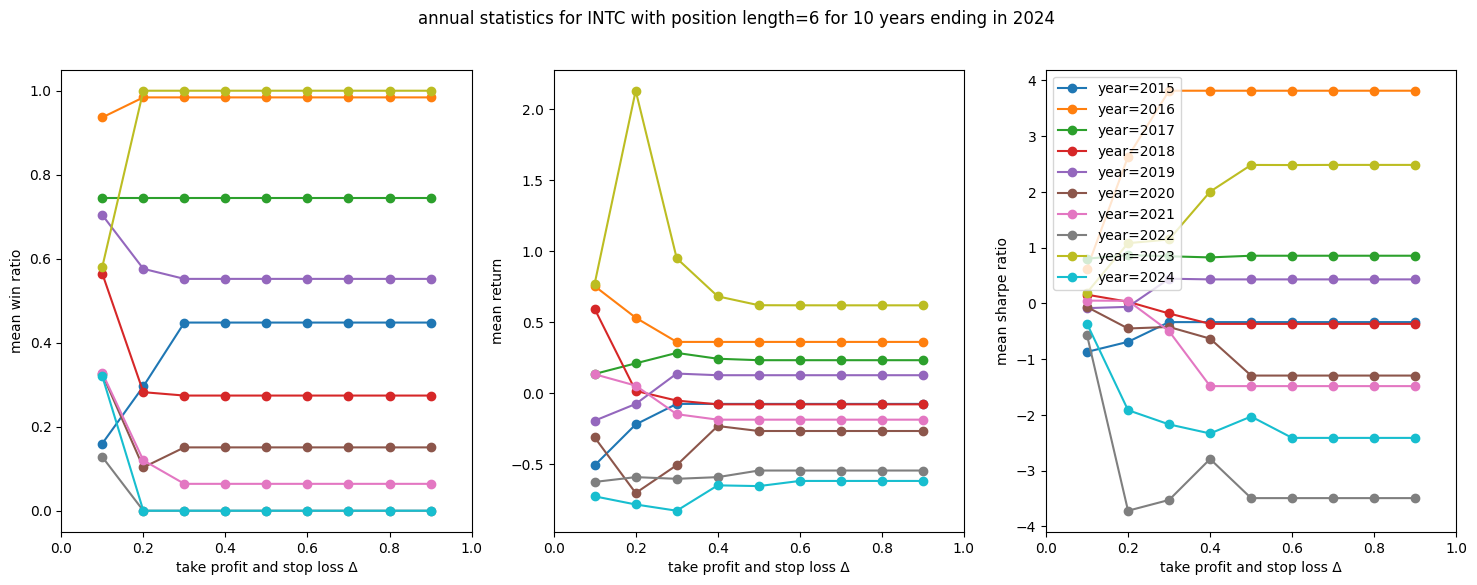

In [12]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=['INTC'], price_metric='Close',
    position_length=6,
)

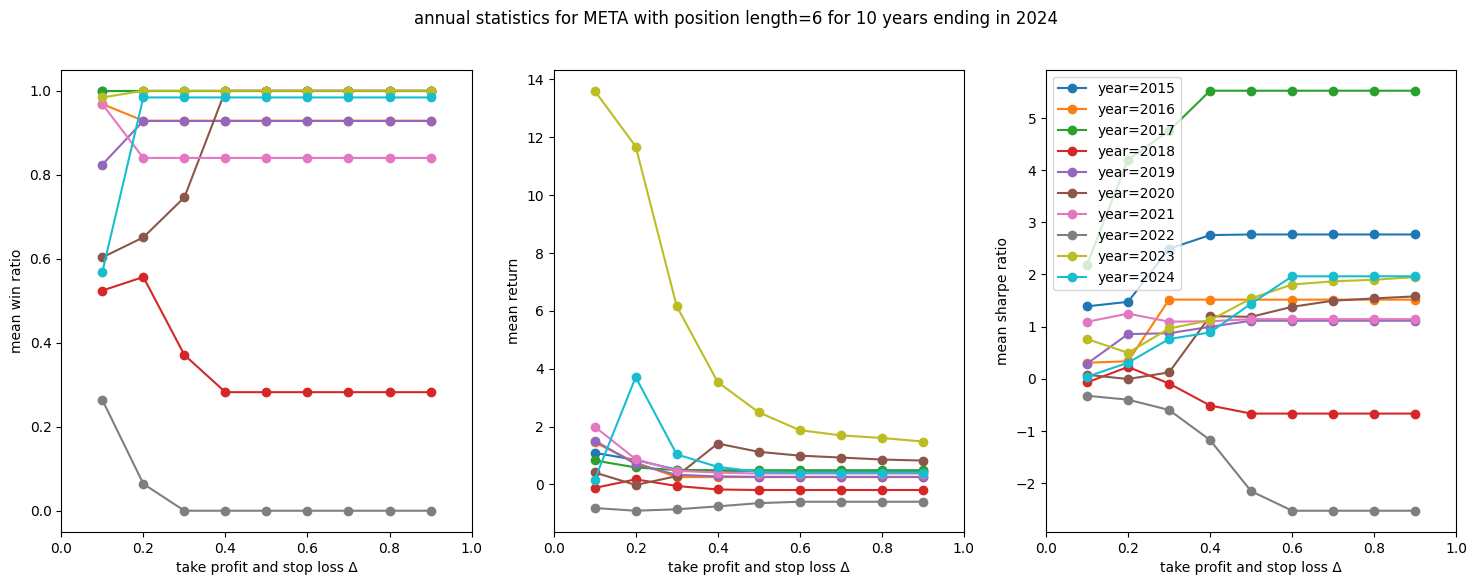

In [13]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=['META'], price_metric='Close',
    position_length=6,
)

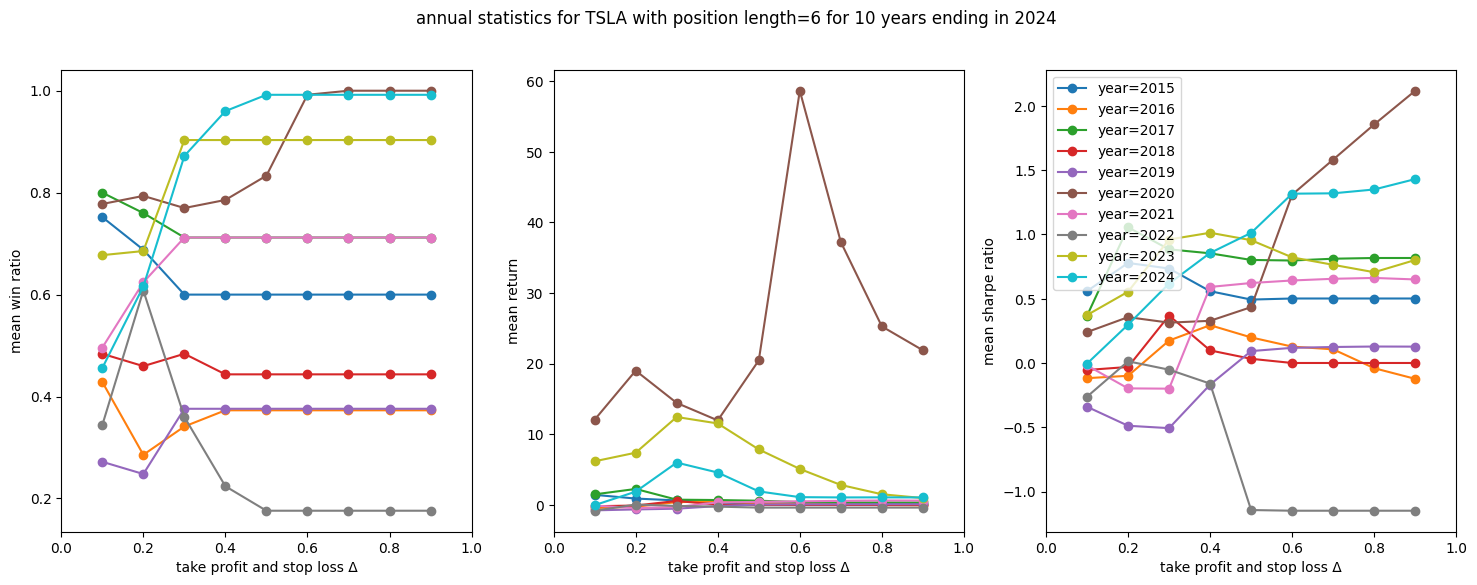

In [14]:
plot_yearly_goodness_all(
    df=df_nasdaq_10, tickers=['TSLA'], price_metric='Close',
    position_length=6,
)

In [15]:
def third(series):
    return take(series, 2)

def strategy_returns(prices, position_length, take_profit=None, stop_loss=None):
    returns_active_days = []
    for i, start_price in enumerate(prices[:-(position_length)]):
        final_price, active_days = execute_strategy(
            prices=prices[i+1:i+position_length+1],
            take_profit_price=start_price*take_profit if take_profit is not None else None,
            stop_loss_price=start_price*stop_loss if stop_loss is not None else None,
        )
        r = (final_price - start_price) / start_price
        returns_active_days.append((r, active_days))
    return returns_active_days

def strategy_goodness(df, tickers, price_metric, strategy_func):
    qs = []
    for ticker in tickers:
        prices = second(extract_series(df, ticker, price_metric))
        returns_active_days = strategy_func(prices)
        q, active_days = np.mean(first(returns_active_days)), np.mean(returns_active_days)
        if np.isnan(q) or q > 100: continue
        qs.append((q, active_days))
    q = np.mean(qs)
    return np.mean(first(qs)), np.mean(second(qs))

def plot_goodness_all(df, tickers, price_metric, take_profit_mul=1.0):
    monthly_trading_days = 21
    position_lengths = [1, 3, 6, 9, 12, 24, 36]
    deltas = np.arange(0.1, 1.0, 0.1)
    metric_funcs = [
        (mean_return, "return"),
        (mean_return, "active days"),
    ]
    qs = defaultdict(lambda: [])
    for position_length in position_lengths:
        for delta in deltas:
            q, active_days = strategy_goodness(
                df=df, tickers=tickers, price_metric='Close',
                strategy_func=lambda prices: strategy_returns(prices, position_length*monthly_trading_days,
                                                              take_profit=1.0 + take_profit_mul*delta,
                                                              stop_loss=  1.0 -                 delta),
            )
            qs[position_length].append((delta, q, active_days))
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=False, figsize=(18, 6))
    plt.xlabel(f'take profit and stop loss Δ')
    plt.suptitle(f'mean statistics for {tickers if len(tickers)>1 else tickers[0]} for 10 years ending in 2024',)
    legends = []
    for position_length in position_lengths:
        legends.append(f'position length={position_length} mos')
        axes[0].plot(first(qs[position_length]), second(qs[position_length]), marker='o')
        axes[0].set_xlabel(f'take profit and stop loss Δ')
        axes[0].set_ylabel(f'mean non-normalized return')
        axes[0].set_xlim((0.0, 1.0))
    for position_length in position_lengths:
        axes[1].plot(first(qs[position_length]), third(qs[position_length]), marker='o')    
        axes[1].set_xlabel(f'take profit and stop loss Δ')
        axes[1].set_ylabel(f'mean active days in position')
        axes[1].set_xlim((0.0, 1.0))
    plt.legend(legends)

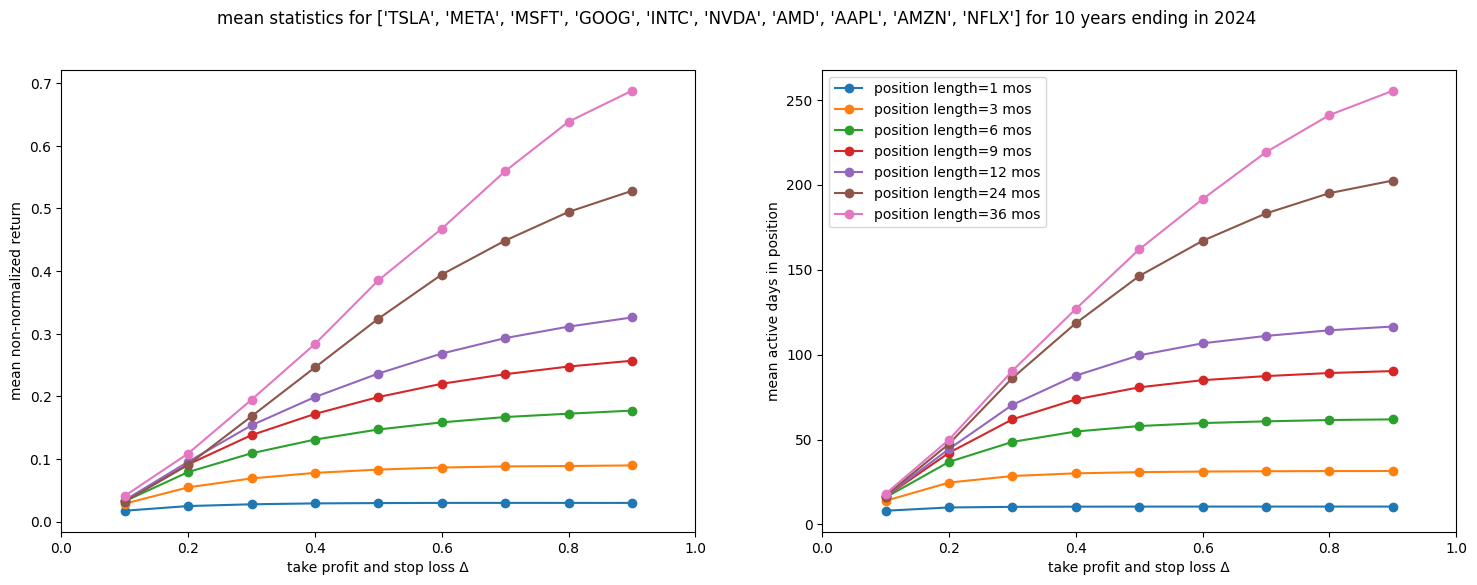

In [16]:
plot_goodness_all(
    df=df_nasdaq_10, tickers=tickers, price_metric='Close',
)

In [17]:
returns =     [1, 2, 3]
active_days = [1,  2,  3]
daily_returns = [np.exp(np.log(1+r)/d)-1 for r, d in zip(returns, active_days)]
annualized_returns = [(1+r)**252-1 for r in daily_returns]

In [18]:
daily_returns

[np.float64(1.0),
 np.float64(0.7320508075688774),
 np.float64(0.5874010519681994)]